# Project Introduction

In this project, I'm going to analyze UK housing prices from 1978 to 2023 using the Local Authority Housing Statistics (LAHS) dataset. The goal is to identify trends, patterns, and factors that influence price changes over time. By understanding these patterns, I aim to provide insights that can assist policymakers, urban planners, and homebuyers in making informed decisions. I will clean and preprocess the data to ensure accuracy, explore trends through visualizations, and apply a regression model to investigate the factors that affect housing prices.

---

Let's start by importing the libraries we will use in this project.


In [55]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import norm



Load the dataset

In [56]:
df = pd.read_csv("/content/LAHS_open_data_1978-79_to_2022-23.csv")


Display the first few rows of the dataset to understand its structure

In [57]:
df.head()

,local_authority,local_authority_code,LAD22NM,LAD22CD,LAD22TYPE,region_name,region_code,metropolitan_county_name,metropolitan_county_code,county_name,...,f1a,f16a,f16b,i13a,i14a,j1aa,j1ab,i1a,i2a,i2ca
0,Adur,E07000223,Adur,E07000223,E07,South East,E12000008,NaN,NaN,West Sussex,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]
1,Adur,E07000223,Adur,E07000223,E07,South East,E12000008,NaN,NaN,West Sussex,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]
2,Adur,E07000223,Adur,E07000223,E07,South East,E12000008,NaN,NaN,West Sussex,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]
3,Adur,E07000223,Adur,E07000223,E07,South East,E12000008,NaN,NaN,West Sussex,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]
4,Adur,E07000223,Adur,E07000223,E07,South East,E12000008,NaN,NaN,West Sussex,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]


---

As we can see from the results, the dataset contains a variety of columns, each representing different aspects of housing data, such as region names, local authority codes, and various numerical indicators.

---

Next, let's display a summary of the dataset to see the data types and check for any potential issues in the column types.



In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15483 entries, 0 to 15482
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   local_authority           15483 non-null  object
 1   local_authority_code      15483 non-null  object
 2   LAD22NM                   15483 non-null  object
 3   LAD22CD                   15483 non-null  object
 4   LAD22TYPE                 15483 non-null  object
 5   region_name               15483 non-null  object
 6   region_code               15483 non-null  object
 7   metropolitan_county_name  1620 non-null   object
 8   metropolitan_county_code  1620 non-null   object
 9   county_name               10161 non-null  object
 10  county_code               10161 non-null  object
 11  Year                      15483 non-null  object
 12  a2ia                      15483 non-null  object
 13  a2iaa                     15483 non-null  object
 14  a2iab                 


---

Our dataset contains a total of 15,483 records and 35 columns, with several fields having missing values that we will handle in the data cleaning step.

---


Let's check for missing values to identify columns that may need cleaning



In [59]:

missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
local_authority                 0
local_authority_code            0
LAD22NM                         0
LAD22CD                         0
LAD22TYPE                       0
region_name                     0
region_code                     0
metropolitan_county_name    13863
metropolitan_county_code    13863
county_name                  5322
county_code                  5322
Year                            0
a2ia                            0
a2iaa                           0
a2iab                           0
a4c                             0
a4d                             0
d4a                             0
d8a                             0
i3fa                            0
i3fb                            0
h5a                             0
h8a                             0
h9a                             0
e1a                             0
f1a                             0
f16a                            0
f16b                            0
i13a                            

---

From the missing values summary, we see that `metropolitan_county_name` and `metropolitan_county_code` have a significant amount of missing data, while other columns are mostly complete.

---

We saw earlier that some columns contain `[z]` and `[x]`, which represent missing values. Let's replace these placeholders with `NaN` to standardize missing values across the dataset.



In [60]:
# Replace '[z]' and '[x]' with NaN
df.replace({'[z]': pd.NA, '[x]': pd.NA}, inplace=True)

Let's drop specified columns with too many missing values and columns that have 0 as values in all rows

In [61]:
df.drop(columns=["h9a", "f1a", "i2ca"], inplace=True)

Now we define the columns to convert to numeric and fill NaN values with the mean

In [62]:
columns_to_fill = ["a2ia", "a2iaa", "a2iab", "a4c", "a4d", "d4a", "d8a", "i3fa", "i3fb", "h5a",
                   "h8a", "e1a", "f16a", "f16b", "i13a", "i14a", "j1aa", "j1ab", "i1a", "i2a"]

# Convert only the specified columns to numeric, coercing errors to NaN
df[columns_to_fill] = df[columns_to_fill].apply(pd.to_numeric, errors='coerce')

# Fill NaN values with the mean for the specified columns
df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].mean())

After going through the dataset documentation, I decided to rename the alphanumeric identifiers with their respective descriptive names based on the documentation notes.

In [63]:
# Apply column renaming using the provided column mapping dictionary
column_mapping = {
    "a2ia": "Total_All_Dwellings",
    "a2iaa": "Total_Social_Rent_Dwellings",
    "a2iab": "Total_Affordable_Rent_Dwellings",
    "a4c": "New_Builds",
    "a4d": "Acquisitions",
    "d4a": "Total_Lettings_Existing_Social_Tenants",
    "d8a": "Total_Dwellings_Let_New_Tenants_Social_Housing",
    "i3fa": "LA_Total_Units_Without_Developer_Contributions",
    "i3fb": "LA_Total_Units_With_Developer_Contributions",
    "h5a": "Current_Tenants_Arrears",
    "h8a": "Rent_Arrears_Written_Off",
    "e1a": "Vacant_Dwellings_LA_Owned",
    "f16a": "Total_Non_Decent_Dwellings",
    "f16b": "Total_Cost_To_Make_Dwellings_Decent",
    "i13a": "Financial_Contributions_s106_Received",
    "i14a": "Financial_Contributions_s106_Spent",
    "j1aa": "LA_New_Social_Rent_Start_Without_Developer_Contributions",
    "j1ab": "LA_New_Social_Rent_Start_With_Developer_Contributions",
    "i1a": "Units_Completed_Populations_Less_Than_3000",
    "i2a": "Units_On_Rural_Exception_Sites"
}
df.rename(columns=column_mapping, inplace=True)

To ensure consistency, I will parse the 'Year' column by extracting the starting year from each range and converting it to a datetime format.

In [64]:
# Ensure dates are parsed correctly by extracting the starting year from 'Year'
df['Year'] = df['Year'].str.split('-').str[0]  # Extract the first part of the range
df['Year'] = pd.to_datetime(df['Year'], format='%Y', errors='coerce')  # Convert to datetime format

In [65]:
df.head()

,local_authority,local_authority_code,LAD22NM,LAD22CD,LAD22TYPE,region_name,region_code,metropolitan_county_name,metropolitan_county_code,county_name,...,Rent_Arrears_Written_Off,Vacant_Dwellings_LA_Owned,Total_Non_Decent_Dwellings,Total_Cost_To_Make_Dwellings_Decent,Financial_Contributions_s106_Received,Financial_Contributions_s106_Spent,LA_New_Social_Rent_Start_Without_Developer_Contributions,LA_New_Social_Rent_Start_With_Developer_Contributions,Units_Completed_Populations_Less_Than_3000,Units_On_Rural_Exception_Sites
0,Adur,E07000223,Adur,E07000223,E07,South East,E12000008,NaN,NaN,West Sussex,...,6.954614,119.273831,99.643336,69.465429,104.616124,74.538378,2.521673,0.94898,13.194604,3.524053
1,Adur,E07000223,Adur,E07000223,E07,South East,E12000008,NaN,NaN,West Sussex,...,6.954614,47.000000,99.643336,69.465429,104.616124,74.538378,2.521673,0.94898,13.194604,3.524053
2,Adur,E07000223,Adur,E07000223,E07,South East,E12000008,NaN,NaN,West Sussex,...,6.954614,29.000000,99.643336,69.465429,104.616124,74.538378,2.521673,0.94898,13.194604,3.524053
3,Adur,E07000223,Adur,E07000223,E07,South East,E12000008,NaN,NaN,West Sussex,...,6.954614,33.000000,99.643336,69.465429,104.616124,74.538378,2.521673,0.94898,13.194604,3.524053
4,Adur,E07000223,Adur,E07000223,E07,South East,E12000008,NaN,NaN,West Sussex,...,6.954614,38.000000,99.643336,69.465429,104.616124,74.538378,2.521673,0.94898,13.194604,3.524053


Finally, we will save the processed data to avoid redundant cleaning steps in future analyses.

In [66]:
# Save the processed data to avoid redundant cleaning in future steps
df.to_csv("processed_data.csv", index=False)

Now we have a clean dataset ready for analysis. Data preparation and cleaning were completed successfully.

---

### Exploratory Data Analysis (EDA)

In this section, I will explore key characteristics of our dataset. My objective is to gain initial insights and identify any trends or patterns that may be relevant to the study of housing prices. This will involve calculating descriptive statistics, exploring correlations, and visualizing data distributions and outliers.


**Summary Statistics**

To start, let's examine the summary statistics for key columns in our dataset. This will help us understand the range, central tendencies, and variability of our data.

In [67]:
# Load the processed dataset
df = pd.read_csv("/content/processed_data.csv")

# Display summary statistics for key columns to understand central tendencies and range
key_columns = [
    "Total_All_Dwellings", "Total_Social_Rent_Dwellings", "Total_Affordable_Rent_Dwellings",
    "New_Builds", "Acquisitions", "Total_Lettings_Existing_Social_Tenants",
    "Total_Dwellings_Let_New_Tenants_Social_Housing", "LA_Total_Units_Without_Developer_Contributions",
    "LA_Total_Units_With_Developer_Contributions", "Current_Tenants_Arrears", "Rent_Arrears_Written_Off",
    "Vacant_Dwellings_LA_Owned", "Total_Non_Decent_Dwellings", "Total_Cost_To_Make_Dwellings_Decent",
    "Financial_Contributions_s106_Received", "Financial_Contributions_s106_Spent",
    "LA_New_Social_Rent_Start_Without_Developer_Contributions", "LA_New_Social_Rent_Start_With_Developer_Contributions",
    "Units_Completed_Populations_Less_Than_3000", "Units_On_Rural_Exception_Sites"
]

# Display summary statistics
df[key_columns].describe()


,Total_All_Dwellings,Total_Social_Rent_Dwellings,Total_Affordable_Rent_Dwellings,New_Builds,Acquisitions,Total_Lettings_Existing_Social_Tenants,Total_Dwellings_Let_New_Tenants_Social_Housing,LA_Total_Units_Without_Developer_Contributions,LA_Total_Units_With_Developer_Contributions,Current_Tenants_Arrears,Rent_Arrears_Written_Off,Vacant_Dwellings_LA_Owned,Total_Non_Decent_Dwellings,Total_Cost_To_Make_Dwellings_Decent,Financial_Contributions_s106_Received,Financial_Contributions_s106_Spent,LA_New_Social_Rent_Start_Without_Developer_Contributions,LA_New_Social_Rent_Start_With_Developer_Contributions,Units_Completed_Populations_Less_Than_3000,Units_On_Rural_Exception_Sites
count,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.00000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000
mean,2.500945,0.600985,47.323869,9.030749,4.727173,105.982430,197.440313,3.820067,1.47524,0.131882,6.954614,119.273831,99.643336,69.465429,104.616124,74.538378,2.521673,0.948980,13.194604,3.524053
std,6.903288,2.215213,54.746260,15.554563,8.532799,108.407353,159.892528,8.153494,5.02060,1.962394,22.643029,172.360883,120.778769,94.118602,130.895430,113.167648,4.812000,2.834186,17.351104,9.675506
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.500945,0.600985,47.323869,9.030749,4.727173,65.000000,177.500000,3.820067,1.47524,0.131882,6.954614,9.000000,99.643336,69.465429,0.000000,0.000000,2.521673,0.948980,13.194604,0.000000
50%,2.500945,0.600985,47.323869,9.030749,4.727173,105.982430,197.440313,3.820067,1.47524,0.131882,6.954614,59.000000,99.643336,69.465429,104.616124,74.538378,2.521673,0.948980,13.194604,3.524053
75%,2.500945,0.600985,47.323869,9.030749,4.727173,105.982430,197.440313,3.820067,1.47524,0.131882,6.954614,131.000000,99.643336,69.465429,104.616124,74.538378,2.521673,0.948980,13.194604,3.524053
max,324.000000,108.000000,934.000000,461.000000,276.000000,995.000000,999.000000,315.000000,287.00000,244.240000,920.000000,997.000000,999.000000,999.000000,999.000000,999.000000,198.000000,158.000000,630.000000,400.000000


The summary statistics reveal that several columns, such as Total_Affordable_Rent_Dwellings, New_Builds, and Total_Dwellings_Let_New_Tenants_Social_Housing, exhibit high variability and extreme values. This may indicate disparities in housing availability, conditions, and support across different local authorities, which warrants further exploration in our analysis.








**Correlation Analysis**

Next, let's examine the correlation matrix for these key columns. This matrix will help us understand the relationships between different variables, shedding light on potential influences on housing attributes.

In [68]:
# Compute correlation matrix for the selected columns
correlation_matrix = df[key_columns].corr()
correlation_matrix

,Total_All_Dwellings,Total_Social_Rent_Dwellings,Total_Affordable_Rent_Dwellings,New_Builds,Acquisitions,Total_Lettings_Existing_Social_Tenants,Total_Dwellings_Let_New_Tenants_Social_Housing,LA_Total_Units_Without_Developer_Contributions,LA_Total_Units_With_Developer_Contributions,Current_Tenants_Arrears,Rent_Arrears_Written_Off,Vacant_Dwellings_LA_Owned,Total_Non_Decent_Dwellings,Total_Cost_To_Make_Dwellings_Decent,Financial_Contributions_s106_Received,Financial_Contributions_s106_Spent,LA_New_Social_Rent_Start_Without_Developer_Contributions,LA_New_Social_Rent_Start_With_Developer_Contributions,Units_Completed_Populations_Less_Than_3000,Units_On_Rural_Exception_Sites
Total_All_Dwellings,1.000000,0.336680,0.104562,0.014875,0.029030,0.008972,0.007498,0.001210,0.044269,0.002057,0.003734,0.001537,0.000471,0.011351,0.030460,0.033954,-0.003405,-0.003204,0.038503,-0.007003
Total_Social_Rent_Dwellings,0.336680,1.000000,0.002068,0.011514,0.000917,0.000152,0.000187,-0.000522,0.012678,0.001394,0.001734,-0.000493,-0.000165,0.015559,-0.006825,0.001007,-0.000602,-0.000951,-0.018909,-0.006728
Total_Affordable_Rent_Dwellings,0.104562,0.002068,1.000000,0.324480,0.418978,0.181717,0.205267,0.217952,0.085311,0.018052,0.038608,0.134590,0.084242,0.066610,0.016478,0.026592,-0.005564,-0.012848,0.008209,-0.011292
New_Builds,0.014875,0.011514,0.324480,1.000000,0.236210,0.253645,0.199794,0.386284,0.129077,0.015993,0.023616,0.152302,0.064317,0.054276,0.046794,0.042655,0.137276,0.071696,-0.021090,-0.011825
Acquisitions,0.029030,0.000917,0.418978,0.236210,1.000000,0.188106,0.190779,0.176497,0.047525,0.001782,0.030654,0.153593,0.117453,0.068506,0.065155,0.041314,0.046404,-0.003891,-0.019625,-0.013740
Total_Lettings_Existing_Social_Tenants,0.008972,0.000152,0.181717,0.253645,0.188106,1.000000,0.556206,0.150208,0.038368,0.011233,0.029143,0.440247,0.186162,0.120517,0.020883,0.030331,0.102317,0.038156,-0.032796,-0.006570
Total_Dwellings_Let_New_Tenants_Social_Housing,0.007498,0.000187,0.205267,0.199794,0.190779,0.556206,1.000000,0.126928,0.034363,0.006235,0.051383,0.303490,0.261087,0.178640,0.007292,0.016973,0.090088,0.023957,-0.032542,0.020165
LA_Total_Units_Without_Developer_Contributions,0.001210,-0.000522,0.217952,0.386284,0.176497,0.150208,0.126928,1.000000,0.108780,-0.000757,0.064539,0.126822,0.053512,0.048496,0.022893,0.038386,0.184215,0.050776,-0.039934,-0.009815
LA_Total_Units_With_Developer_Contributions,0.044269,0.012678,0.085311,0.129077,0.047525,0.038368,0.034363,0.108780,1.000000,-0.000783,0.022854,0.017790,0.020076,0.056516,0.012894,0.045379,0.018872,0.130875,0.048150,0.034658
Current_Tenants_Arrears,0.002057,0.001394,0.018052,0.015993,0.001782,0.011233,0.006235,-0.000757,-0.000783,1.000000,0.017012,0.002112,0.007637,0.007900,0.020410,0.043522,-0.002649,-0.001833,0.082870,-0.002747


From the correlation matrix, we can observe some interesting relationships among the variables. For instance, there is a moderate positive correlation between Total_Affordable_Rent_Dwellings and Acquisitions (0.42), indicating that areas with more affordable rent dwellings tend to have higher acquisitions. Additionally, Total_Lettings_Existing_Social_Tenants and Total_Dwellings_Let_New_Tenants_Social_Housing have a strong positive correlation (0.56), suggesting that these variables often increase together, likely reflecting similar social housing trends. There are also some weaker correlations with minimal influence, which will likely have less impact in the further analysis.

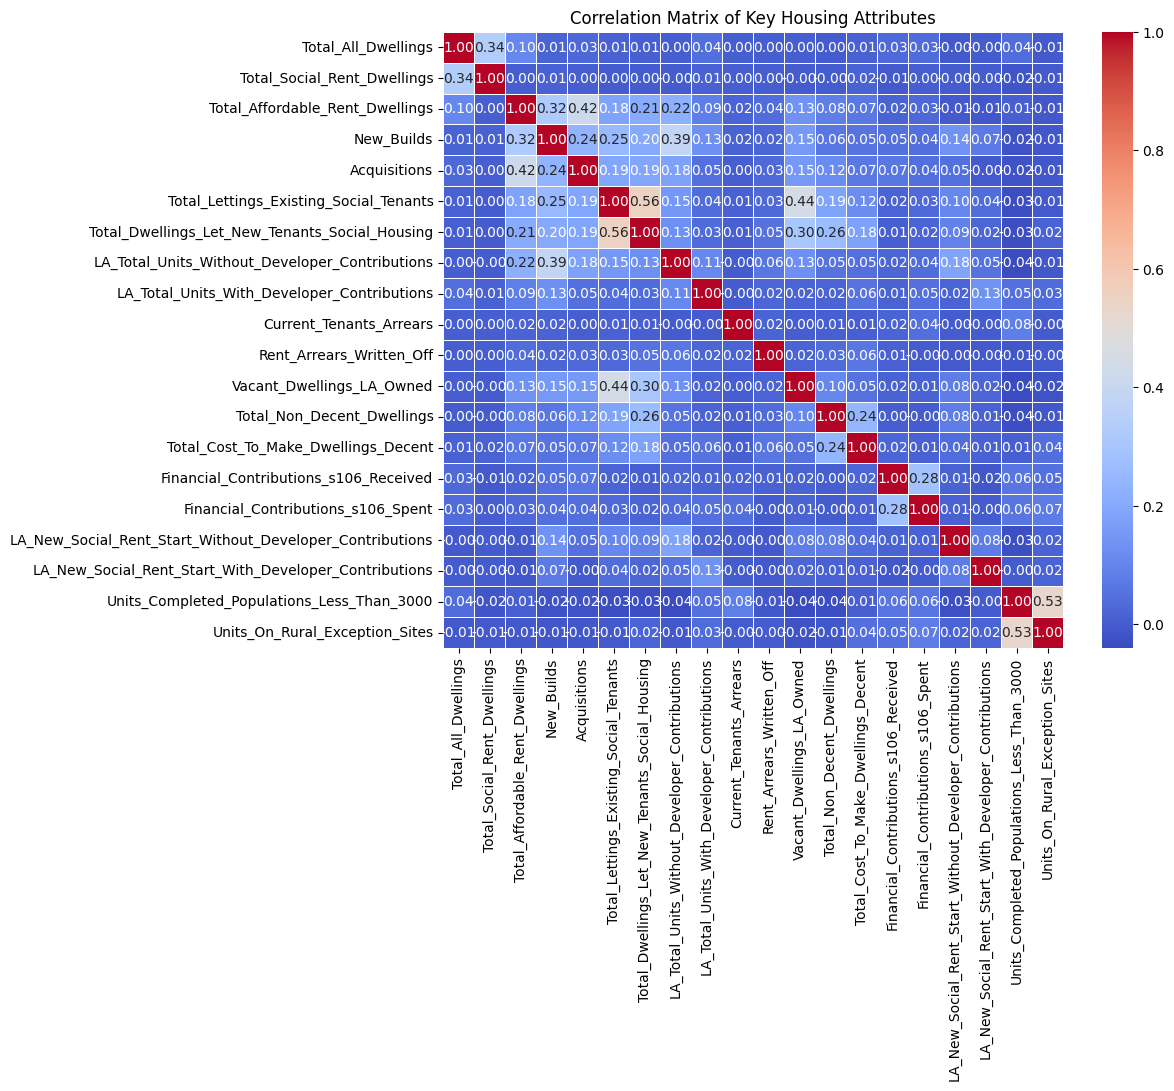

In [69]:
# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Key Housing Attributes")
plt.show()

From the heatmap, we can get a clear view of correlations among different housing attributes. High positive or negative correlations can suggest relationships between attributes that may be worth investigating further.

**Visualizations**

To see the data distribution and identify any outliers, lets plot histograms for the total dwellings, social rent dwellings, and affordable rent dwellings, followed by box plots for these variables to assess their variability and spot potential outliers.

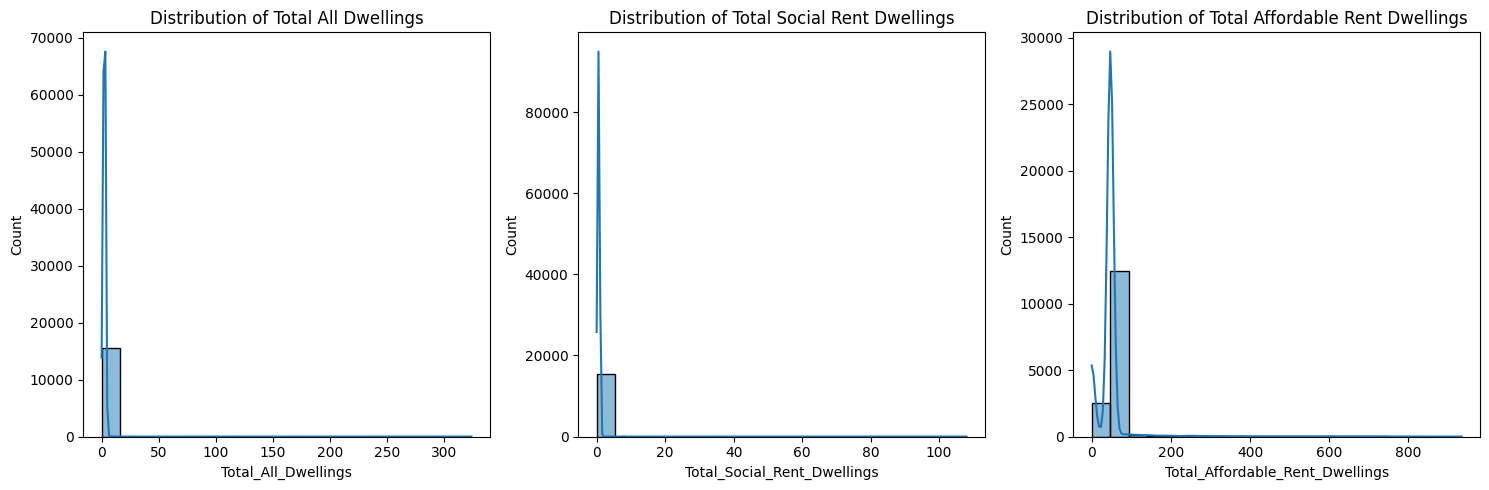

In [70]:
# Step 3: Visualizations

# Histogram for distribution analysis of total dwellings, social rent dwellings, and affordable rent dwellings
plt.figure(figsize=(15, 5))
for i, column in enumerate(["Total_All_Dwellings", "Total_Social_Rent_Dwellings", "Total_Affordable_Rent_Dwellings"], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[column], kde=True, bins=20)
    plt.title(f"Distribution of {column.replace('_', ' ')}")
plt.tight_layout()
plt.show()


From the histograms, we can see that most values for Total_All_Dwellings, Total_Social_Rent_Dwellings, and Total_Affordable_Rent_Dwellings are concentrated at the lower end, with very few entries at the higher values. This distribution indicates a high frequency of lower dwelling counts across regions, suggesting that large numbers of dwellings are less common.

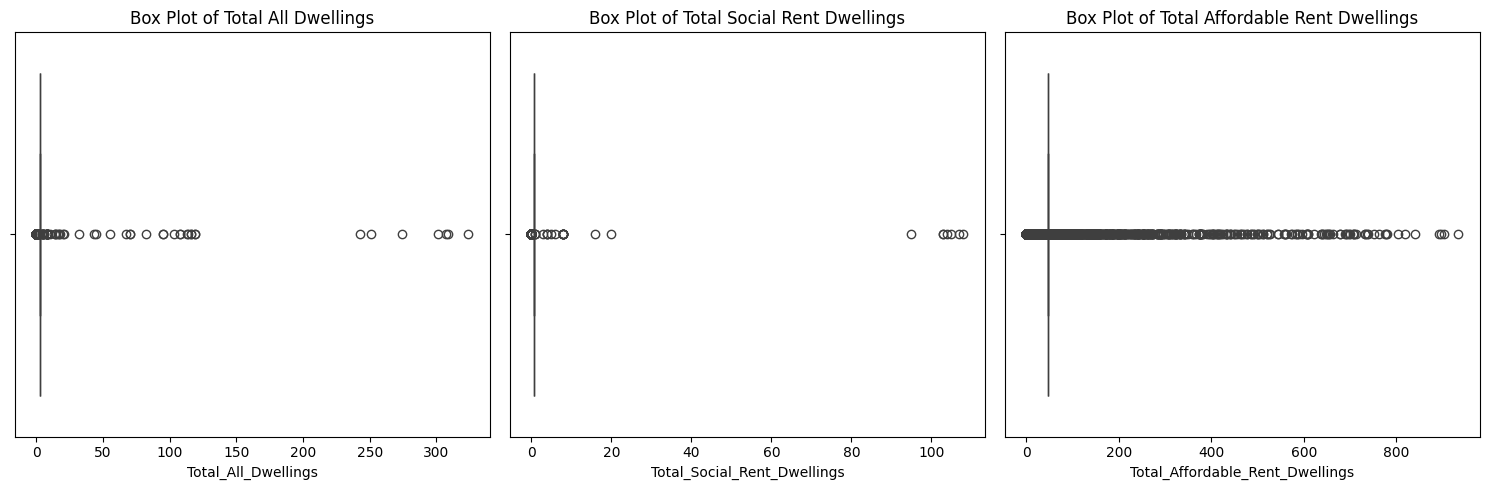

In [71]:
# Box Plots to identify outliers in price-related columns
plt.figure(figsize=(15, 5))
for i, column in enumerate(["Total_All_Dwellings", "Total_Social_Rent_Dwellings", "Total_Affordable_Rent_Dwellings"], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f"Box Plot of {column.replace('_', ' ')}")
plt.tight_layout()
plt.show()

The box plots reveal that Total_All_Dwellings, Total_Social_Rent_Dwellings, and Total_Affordable_Rent_Dwellings contain numerous outliers, indicating that most values are low with a few significantly higher entries in each category.

**Analyze the Average Housing Prices Across Neighborhoods**

**Goal:** To identify price differences between neighborhoods.

**Calculate Averages**

First, let's group the data by region and calculate the average housing prices for the year 2021 to observe any regional price disparities.

In [72]:
# Calculate Averages: Let's group data by region and calculate the average housing prices for the year 2021
year = '2021'
filtered_data = df[df['Year'].str.contains(year)]

# Calculate the average of 'Total_All_Dwellings' by region
avg_housing_prices = filtered_data.groupby('region_name')['Total_All_Dwellings'].mean().sort_values(ascending=False)

# Display the average housing prices for verification
print("Average Housing Prices by Region for the Year", year)
print(avg_housing_prices)


Average Housing Prices by Region for the Year 2021
region_name
North East                  33.417454
East Midlands                2.500945
East of England              2.500945
London                       2.500945
North West                   2.500945
South East                   2.500945
South West                   2.500945
West Midlands                2.500945
Yorkshire and The Humber     2.500945
Name: Total_All_Dwellings, dtype: float64


The North East stands out with a significantly higher average housing price than all other regions, which are clustered around similar lower values. This suggests that the North East might have unique factors, such as property demand or availability of social housing, that influence its higher average price.

To visually represent the regional differences, we will plot a bar chart of the average housing prices by region for the year 2021.

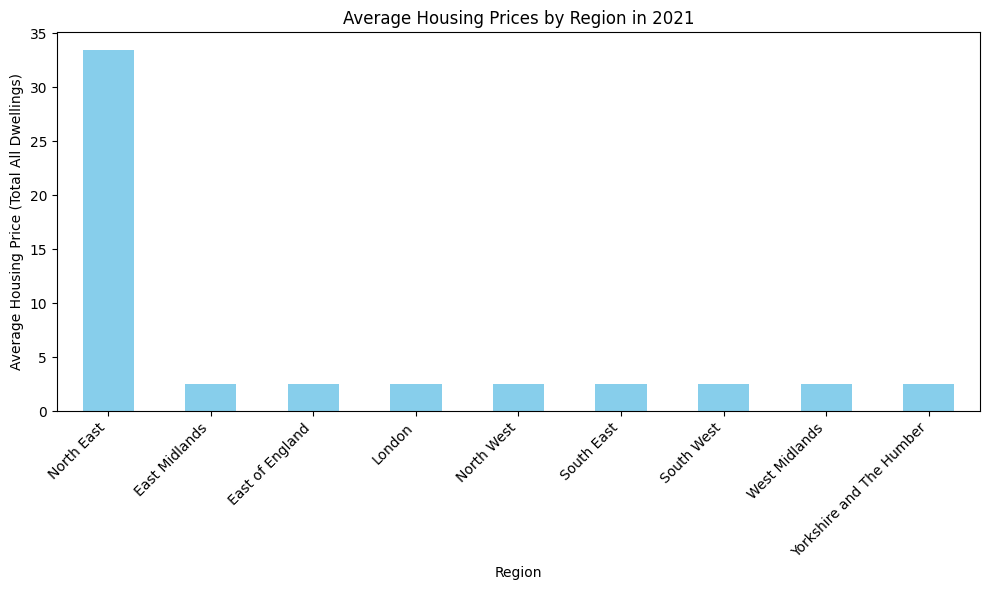

In [73]:
# Use a bar chart to display average housing prices by neighborhood/region for the selected year
plt.figure(figsize=(10, 6))
avg_housing_prices.plot(kind='bar', color='skyblue')
plt.title(f"Average Housing Prices by Region in {year}")
plt.xlabel("Region")
plt.ylabel("Average Housing Price (Total All Dwellings)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


As seen in the bar chart, the North East region shows a a huge difference in average housing prices compared to other regions, suppoting the numerical findings.

**Visualize Trends Over Time**

To understand trends over time, we plot the average housing prices across all regions from the start year to the latest available year.

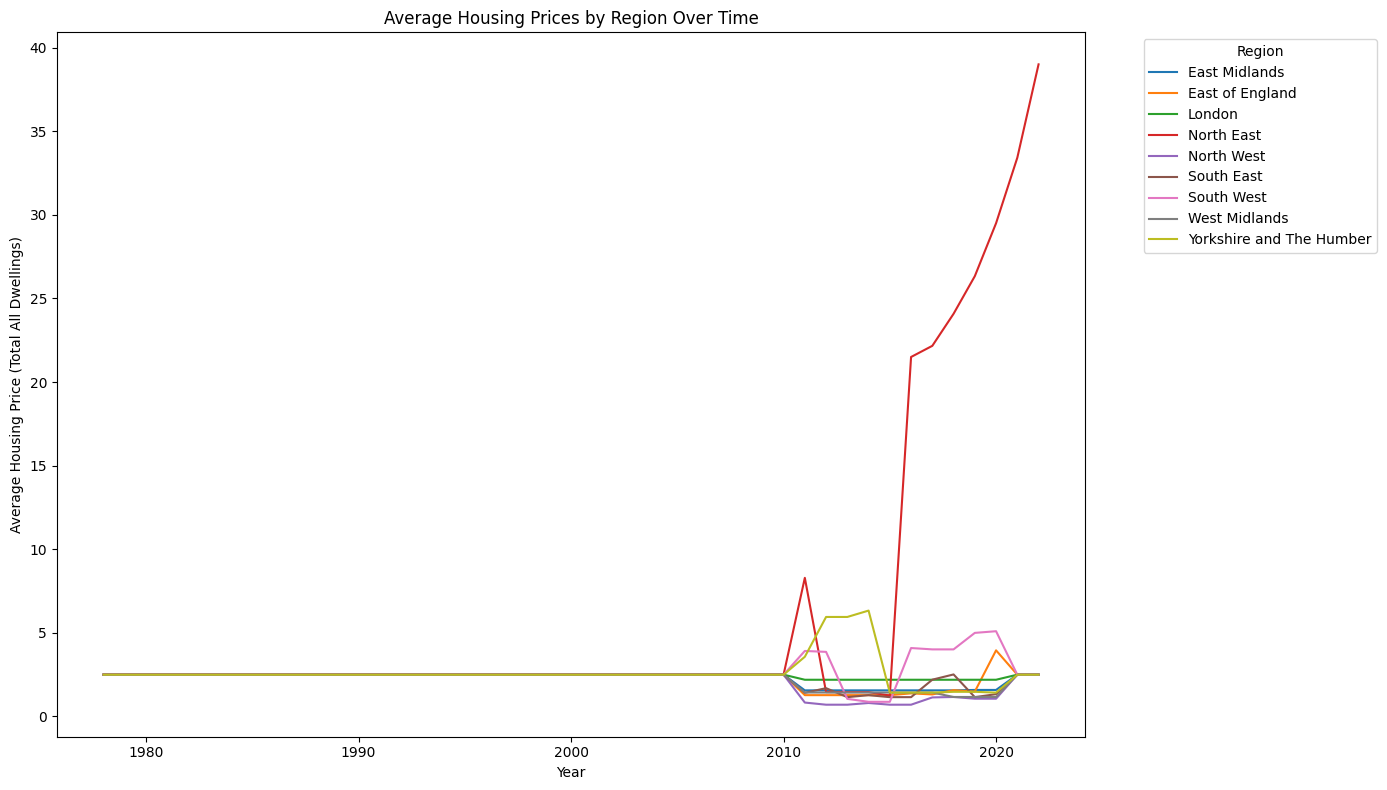

In [74]:
# Plot the trends over time for each region
df['Year'] = pd.to_datetime(df['Year'], errors='coerce').dt.year

# Calculate average housing prices by region and year
avg_prices_by_region_year = df.groupby(['Year', 'region_name'])['Total_All_Dwellings'].mean().unstack()

plt.figure(figsize=(14, 8))
for region in avg_prices_by_region_year.columns:
    plt.plot(avg_prices_by_region_year.index, avg_prices_by_region_year[region], label=region)

plt.title("Average Housing Prices by Region Over Time")
plt.xlabel("Year")
plt.ylabel("Average Housing Price (Total All Dwellings)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


The line plot shows that the North East region experienced a substantial increase in average housing prices over time, especially in recent years. Other regions have relatively stable trends with minimal fluctuations, indicating regional factors driving prices in the North East specifically.








**Study the Impact of Government Housing Policies on Regional Housing Prices**

In this section, let's take a look at how government policies impact regional housing prices. By comparing housing price trends in regions with high versus low government intervention, we can assess whether policies significantly influence affordability.


We start by selecting the policy-related variables that represent government intervention in housing, such as financial contributions and social rent starts. We also include `Total_All_Dwellings` to track housing prices, along with `region_name` and `Year` to allow for regional analysis.


In [ ]:
# Define policy-related variables
policy_features = [
    'Financial_Contributions_s106_Received',
    'Financial_Contributions_s106_Spent',
    'LA_New_Social_Rent_Start_Without_Developer_Contributions',
    'LA_New_Social_Rent_Start_With_Developer_Contributions'
]

# Add 'Total_All_Dwellings' to capture housing prices
features = policy_features + ['Total_All_Dwellings', 'region_name', 'Year']


Here, we create a subset of the dataset that includes only the selected features. This subset will serve as the foundation for our analysis, focusing specifically on policy-related variables and housing prices.


In [ ]:
# Select relevant columns for the analysis and create a copy
policy_df = df[features].copy()

To quantify the level of government intervention, we calculate a `Total_Policy_Intervention` score for each region and year by summing up the values of the selected policy-related variables.


In [ ]:
# Calculate total government intervention as the sum of all policy-related variables
policy_df['Total_Policy_Intervention'] = policy_df[policy_features].sum(axis=1)

To compare regions with different levels of intervention, we categorize them into "High Intervention" and "Low Intervention" groups based on the median intervention score. This classification allows us to observe potential differences in housing price trends between these two groups.


In [ ]:
# Calculate the median intervention level
median_intervention = policy_df['Total_Policy_Intervention'].median()

# Create a new column to categorize regions based on policy intervention
policy_df['Intervention_Level'] = policy_df['Total_Policy_Intervention'].apply(
    lambda x: 'High Intervention' if x >= median_intervention else 'Low Intervention'
)
print(policy_df['Intervention_Level'].value_counts())


Intervention_Level
High Intervention    10322
Low Intervention      5161
Name: count, dtype: int64


The data shows that regions classified as "High Intervention" outnumber those in "Low Intervention" by nearly two-to-one, indicating more areas received substantial policy support.


We aggregate the data by year and intervention level to calculate the average housing prices for each group. This provides a clearer view of how housing prices vary over time based on the level of government intervention.


In [ ]:
# Group by year, intervention level, and calculate the mean housing prices
policy_trends = policy_df.groupby(['Year', 'Intervention_Level'])['Total_All_Dwellings'].mean().reset_index()
print(policy_trends.head(-5))

         Year Intervention_Level  Total_All_Dwellings
0  1978-01-01  High Intervention             2.500945
1  1979-01-01  High Intervention             2.500945
2  1980-01-01  High Intervention             2.500945
3  1981-01-01  High Intervention             2.500945
4  1982-01-01  High Intervention             2.500945
..        ...                ...                  ...
58 2018-01-01  High Intervention             4.050824
59 2018-01-01   Low Intervention             1.825329
60 2019-01-01  High Intervention             3.503896
61 2019-01-01   Low Intervention             1.985671
62 2020-01-01  High Intervention             3.966905

[63 rows x 3 columns]


From the yearly average housing prices table, regions with high government intervention maintained relatively stable prices over time, with notable increases only after 2015.


Plot Housing Prices Over Time

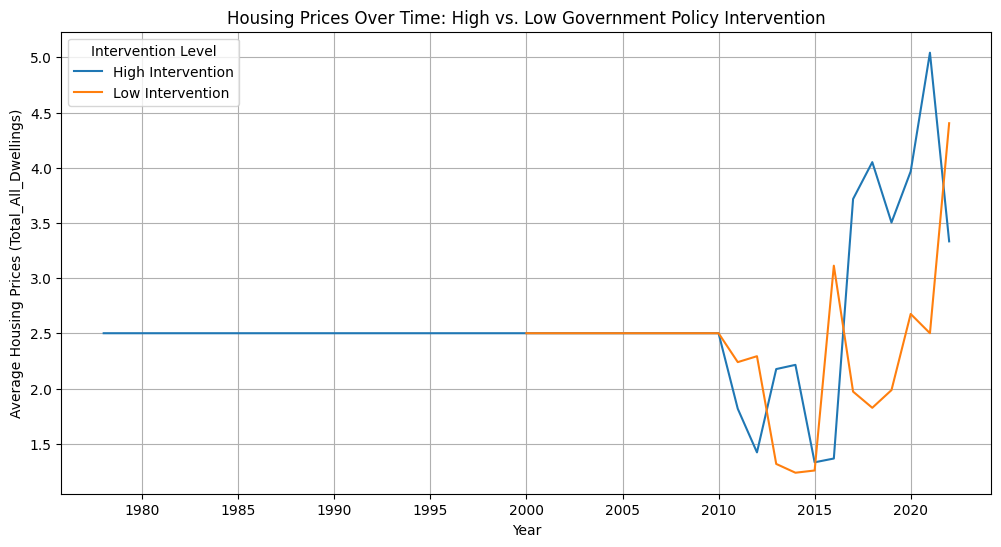

In [ ]:
# Plot the data
plt.figure(figsize=(12, 6))
for label, df_sub in policy_trends.groupby('Intervention_Level'):
    plt.plot(df_sub['Year'], df_sub['Total_All_Dwellings'], label=label)

# Customize the plot
plt.title('Housing Prices Over Time: High vs. Low Government Policy Intervention')
plt.xlabel('Year')
plt.ylabel('Average Housing Prices (Total_All_Dwellings)')
plt.legend(title='Intervention Level')
plt.grid(True)
plt.show()

The plot reveals that since 2010, regions with high government intervention tend to have higher housing prices compared to those with low intervention, suggesting a potential correlation between policy support and increased housing prices over time.


**Analyze Urban Trends and Their Correlation with House Prices in Major Cities**

In this section, I’ll analyze urban trends and their correlation with house prices in major cities. By categorizing local authorities into urban and rural classifications, I aim to uncover any significant price differences and trends over time.

Let's start by defining which authorities we consider urban based on the datset documentation. We will then categorize all authorities as either urban or rural.

In [ ]:
# Define a simple list to classify certain authorities as urban based on general knowledge
# In practice, we would ideally have population size data for more accurate classification
urban_authorities = [
    'Birmingham', 'Manchester', 'Liverpool', 'Leeds', 'Sheffield', 'Bristol',
    'Nottingham', 'Leicester', 'Coventry', 'Bradford', 'Wakefield', 'Cardiff',
    'Sunderland', 'Newcastle upon Tyne', 'Kingston upon Hull', 'Southampton',
    'Portsmouth', 'London'
]

# Create a new column 'Urban_Rural' in the DataFrame based on the classification
df['Urban_Rural'] = df['local_authority'].apply(lambda x: 'Urban' if x in urban_authorities else 'Rural')

# Display the count of Urban and Rural classifications for validation
print(df['Urban_Rural'].value_counts())


Urban_Rural
Rural    14763
Urban      720
Name: count, dtype: int64


As we can see, the majority of areas are classified as Rural, while a smaller portion falls under Urban.

Next, we'll group the data by year and urban/rural classification to calculate the average housing prices over time for each category.

In [ ]:
# Group data by Year and Urban/Rural classification to get the average housing prices over time
urban_rural_price_trends = df.groupby(['Year', 'Urban_Rural'])['Total_All_Dwellings'].mean().reset_index()

# Display the first few rows to confirm the grouped data
print(urban_rural_price_trends.head(-5))


         Year Urban_Rural  Total_All_Dwellings
0  1978-01-01       Rural             2.500945
1  1978-01-01       Urban             2.500945
2  1979-01-01       Rural             2.500945
3  1979-01-01       Urban             2.500945
4  1980-01-01       Rural             2.500945
..        ...         ...                  ...
80 2018-01-01       Rural             2.900470
81 2018-01-01       Urban             1.719400
82 2019-01-01       Rural             2.746328
83 2019-01-01       Urban             1.719400
84 2020-01-01       Rural             3.200150

[85 rows x 3 columns]


We now have average housing prices segmented by urban and rural classifications over time, which helps us observe trends in each area type.

Let's visualize the average housing prices over time for urban and rural areas to see if any notable trends appear.

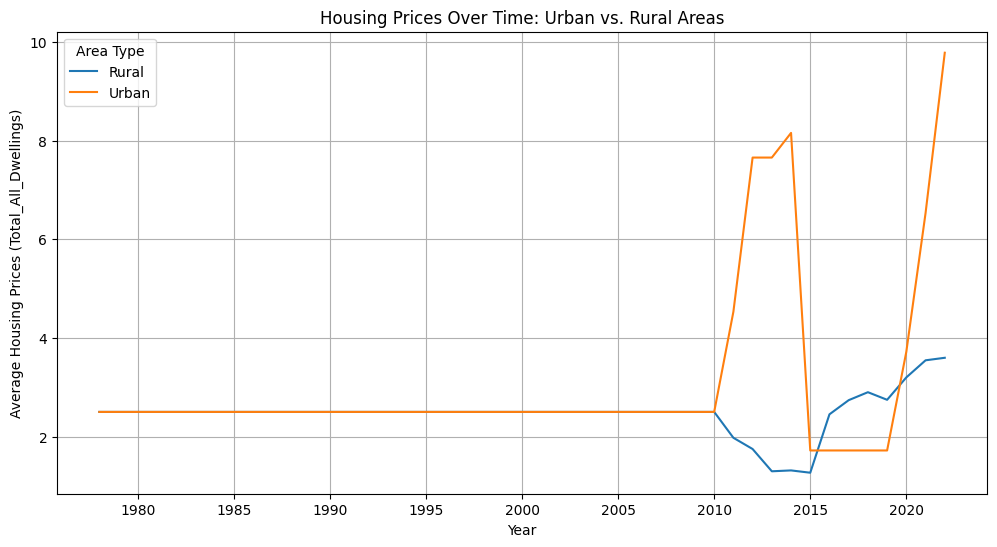

In [ ]:
# Plotting average housing prices over time for Urban and Rural areas
plt.figure(figsize=(12, 6))
for label, df_sub in urban_rural_price_trends.groupby('Urban_Rural'):
    plt.plot(df_sub['Year'], df_sub['Total_All_Dwellings'], label=label)

# Customize the plot
plt.title('Housing Prices Over Time: Urban vs. Rural Areas')
plt.xlabel('Year')
plt.ylabel('Average Housing Prices (Total_All_Dwellings)')
plt.legend(title='Area Type')
plt.grid(True)
plt.show()


From the plot above, we can observe fluctuations in housing prices in urban and rural areas, with urban areas showing sharper changes in recent years.

Finally, let's examine the relationship between the number of new builds and housing prices, using a scatter plot to highlight any patterns between urban and rural areas.

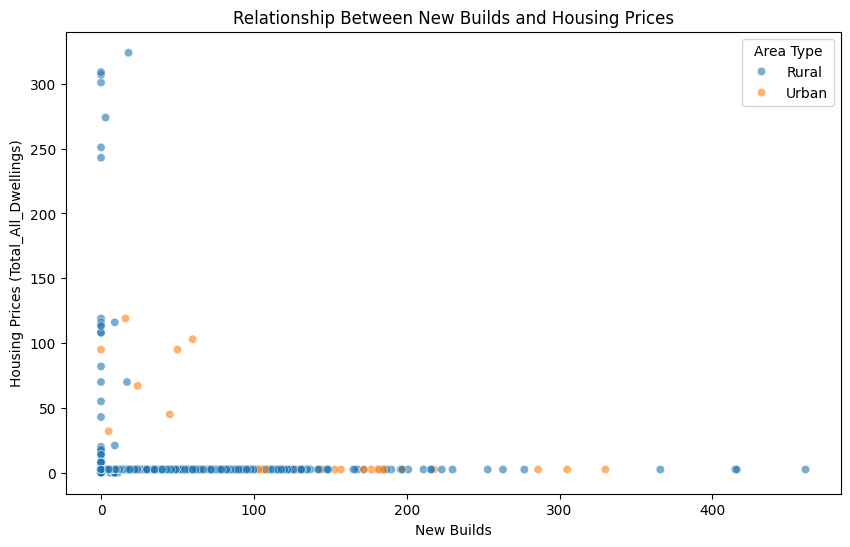

In [ ]:
# Scatter plot showing the relationship between new builds and housing prices
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='New_Builds', y='Total_All_Dwellings', hue='Urban_Rural', alpha=0.6)
plt.title("Relationship Between New Builds and Housing Prices")
plt.xlabel("New Builds")
plt.ylabel("Housing Prices (Total_All_Dwellings)")
plt.legend(title='Area Type')
plt.show()



The scatter plot suggests that there’s no clear linear relationship between the number of new builds and housing prices, but urban areas appear to have slightly higher prices overall.

**Identify Factors Influencing Price Changes**

In this section, I am going to identify factors influencing housing price changes by conducting multiple linear regression. This analysis will help us quantify the impact of various features on housing prices.


Let's start by defining the Dependent and Independent Variables.

we define Total_All_Dwellings as the dependent variable representing housing prices. The independent variables include a selection of features that might influence housing prices, such as new builds, acquisitions, and affordable rent dwellings.

In [75]:
# Define the dependent and independent variables
target = 'Total_All_Dwellings'  # Dependent variable representing housing prices

features = [
    "Total_Social_Rent_Dwellings", "Total_Affordable_Rent_Dwellings",
    "New_Builds", "Acquisitions", "Total_Lettings_Existing_Social_Tenants",
    "Total_Dwellings_Let_New_Tenants_Social_Housing", "LA_Total_Units_Without_Developer_Contributions",
    "LA_Total_Units_With_Developer_Contributions", "Current_Tenants_Arrears", "Rent_Arrears_Written_Off",
    "Vacant_Dwellings_LA_Owned", "Total_Non_Decent_Dwellings", "Total_Cost_To_Make_Dwellings_Decent",
    "Financial_Contributions_s106_Received", "Financial_Contributions_s106_Spent",
    "LA_New_Social_Rent_Start_Without_Developer_Contributions", "LA_New_Social_Rent_Start_With_Developer_Contributions",
    "Units_Completed_Populations_Less_Than_3000", "Units_On_Rural_Exception_Sites"
]

# Prepare the data
X = df[features]
y = df[target]


We then split the data into training and testing sets for analysis.



In [76]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

We then define the MultipleLinearRegressionStatsModel helper class to enhance the model’s accuracy by using stepwise feature selection, allowing us to analyze the relationship between features and housing prices more clearly than with the standard sklearn class.

In [77]:
# Define the helper class with feature selection
class MultipleLinearRegressionStatsModel:
    def __init__(self, feature_names, target_name, feature_selection=False):
        self.feature_names = feature_names
        self.target_name = target_name
        self.model = None
        self.results = None
        self.feature_selection = feature_selection
        self.selected_features = feature_names

    def fit(self, X, y):
        # Feature selection with stepwise method
        if self.feature_selection:
            sfs = SequentialFeatureSelector(estimator=LinearRegression(), forward=True, k_features='best', scoring='r2', cv=5, n_jobs=-1)
            sfs.fit(X, y)
            self.selected_features = list(sfs.k_feature_names_)
        else:
            self.selected_features = self.feature_names

        # Fit the linear regression model using statsmodels
        X = sm.add_constant(X[self.selected_features])
        self.model = sm.OLS(y, X)
        self.results = self.model.fit()

    def predict(self, X_data):
        # Add constant term to new data and make predictions
        X_data = sm.add_constant(X_data[self.selected_features])
        return self.results.predict(X_data)

    def get_summary(self):
        summary_data = {
            'Dep. Variable': self.target_name,
            'No. Observations': len(self.results.model.endog),
            'Model': 'OLS',
            'Df Residuals': self.results.df_resid,
            'R-squared': self.results.rsquared,
            'Adj. R-squared': self.results.rsquared_adj,
            'F-statistic': self.results.fvalue,
            'Prob (F-statistic)': self.results.f_pvalue,
            'Log-Likelihood': self.results.llf,
            'AIC': self.results.aic,
            'BIC': self.results.bic,
            'Standard Error of Estimate': self.results.mse_resid**0.5
        }
        summary = pd.DataFrame([summary_data])
        return summary

    def get_coef_summary(self):
        coef_summary_data = {
            'Coefficient Value': self.results.params,
            'Standard Error': self.results.bse,
            't-value': self.results.tvalues,
            'P>|t|': np.round(self.results.pvalues,4)
        }
        coef_summary = pd.DataFrame(coef_summary_data)
        return coef_summary


In this class, we use SequentialFeatureSelector to perform stepwise selection to identify the most relevant features for predicting housing prices. The class also provides methods to retrieve the regression summary and coefficient details for interpretation.

Fit the Model and Display the Summary and Coefficient Summary

In [78]:
# Create an instance of the regression model with feature selection enabled
reg_model = MultipleLinearRegressionStatsModel(feature_names=features, target_name=target, feature_selection=True)

# Fit the model using the training data
reg_model.fit(X_train, y_train)

# Get the model summary and coefficient summary
model_summary = reg_model.get_summary()
coef_summary = reg_model.get_coef_summary()

# Print the model summary
print("Multiple Linear Regression Summary:")
print(model_summary.transpose())

# Print the coefficient summary
print("\nRegression Coefficients Summary:")
coef_summary


Multiple Linear Regression Summary:
                                              0
Dep. Variable               Total_All_Dwellings
No. Observations                           9289
Model                                       OLS
Df Residuals                             9280.0
R-squared                              0.163328
Adj. R-squared                         0.162606
F-statistic                          226.444798
Prob (F-statistic)                          0.0
Log-Likelihood                    -29494.392906
AIC                                59006.785813
BIC                                59071.015089
Standard Error of Estimate              5.79353

Regression Coefficients Summary:


,Coefficient Value,Standard Error,t-value,P>|t|
const,0.612162,0.176460,3.469132,0.0005
Total_Social_Rent_Dwellings,1.021837,0.025249,40.470730,0.0000
Total_Lettings_Existing_Social_Tenants,-0.000871,0.000586,-1.487111,0.1370
LA_Total_Units_Without_Developer_Contributions,-0.011829,0.008586,-1.377703,0.1683
LA_Total_Units_With_Developer_Contributions,0.079695,0.011314,7.043859,0.0000
Current_Tenants_Arrears,11.521715,1.565255,7.360918,0.0000
Total_Cost_To_Make_Dwellings_Decent,-0.000591,0.000680,-0.868959,0.3849
LA_New_Social_Rent_Start_With_Developer_Contributions,-0.010733,0.022090,-0.485900,0.6270
Units_On_Rural_Exception_Sites,-0.003984,0.006387,-0.623711,0.5328


## Results Analysis:

From the multiple linear regression model results, I got insights into the factors influencing housing prices, as represented by the `Total_All_Dwellings` variable. Below is an interpretation of the key metrics and coefficients:

### Model Summary:
- **R-squared (0.1633)**: This indicates that about 16.33% of the variance in `Total_All_Dwellings` is explained by the selected features. Although this value is relatively low, it suggests that there may be other unaccounted factors influencing housing prices. However, in complex social and economic data, lower R-squared values are common.
- **F-statistic (226.44, p-value = 0.0)**: The F-statistic and its corresponding p-value (0.0) suggest that the model as a whole is statistically significant, indicating that the predictors are jointly explaining a non-zero portion of the variance in the dependent variable.
- **AIC and BIC**: The Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) provide measures for model selection, with lower values indicating a better fit when comparing models. Here, they help in evaluating the overall model quality.

### Coefficient Analysis:
- **Intercept (0.612)**: The baseline value when all predictor variables are zero. It provides a reference point but has limited interpretability on its own.
- **Total_Social_Rent_Dwellings (1.022, p < 0.0001)**: This feature has a positive and significant effect on housing prices. For each additional unit in social rent dwellings, the average housing price increases by 1.022 units, holding other factors constant. This indicates a strong positive relationship between social rent dwellings and overall housing prices.
- **LA_Total_Units_With_Developer_Contributions (0.080, p < 0.0001)**: This variable is also statistically significant, suggesting that units built with developer contributions are associated with higher housing prices, potentially due to enhanced infrastructure and amenities.
- **Current_Tenants_Arrears (11.522, p < 0.0001)**: This coefficient indicates a significant positive relationship, meaning areas with higher tenant arrears are correlated with higher housing prices. This may reflect socioeconomic factors that influence both arrears and price.

#### Other Factors:
- Variables like `Total_Lettings_Existing_Social_Tenants`, `LA_Total_Units_Without_Developer_Contributions`, `Total_Cost_To_Make_Dwellings_Decent`, and others show low or statistically insignificant coefficients. Their high p-values suggest that they may not have a strong influence on the dependent variable, at least within this model's context.
- **Negative Coefficients**: Some factors, such as `Total_Cost_To_Make_Dwellings_Decent`, exhibit negative coefficients, indicating a slight inverse relationship. However, the statistical insignificance of these variables (p > 0.05) means we cannot confidently conclude their impact on housing prices.

### Conclusion:
- Key factors influencing housing prices include `Total_Social_Rent_Dwellings`, `LA_Total_Units_With_Developer_Contributions`, and `Current_Tenants_Arrears`. These factors have significant coefficients and relatively low p-values, indicating a meaningful impact on housing prices.
- The low R-squared value suggests that while these factors provide some insight, additional features or alternative models might better capture the complexity of housing prices.


Let's now evaluate Performance on Test Data

In [79]:
# Use predict() to make predictions on the test set with selected features
y_pred = reg_model.predict(X_test)

# Display performance metrics on the test data
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"\nPerformance Metrics on Test Data:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Performance Metrics on Test Data:
Mean Squared Error (MSE): 1331.6789358994881
Root Mean Squared Error (RMSE): 36.492176365619635
Mean Absolute Error (MAE): 0.9508054793213426


The test data shows an MSE of 1331.68, RMSE of 36.49, and MAE of 0.95, indicating moderate accuracy and potential for improvement.


Let's visualize Residuals to Check Distribution

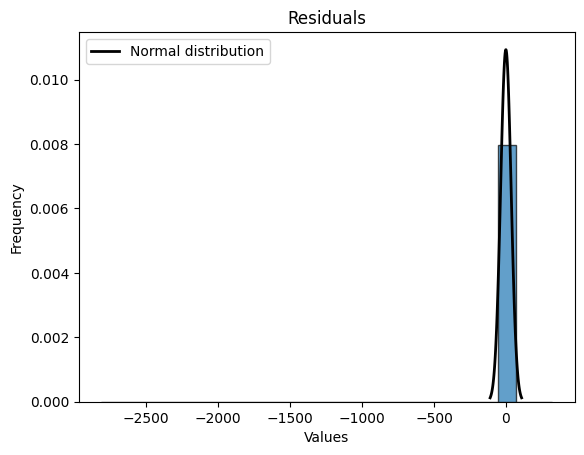

In [80]:
all_residuals = y_test - y_pred
mean, std = np.mean(all_residuals), np.std(all_residuals)

fig, ax = plt.subplots()
ax.hist(all_residuals, bins=25, edgecolor='black', alpha=0.7, density=True)

# Customize labels and title
ax.set_title('Residuals')
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')

# Plot normal distribution overlay
x = np.linspace(mean - 3*std, mean + 3*std, 100)
pdf = norm.pdf(x, mean, std)
ax.plot(x, pdf, 'k', linewidth=2, label='Normal distribution')

plt.legend()
plt.show()

The residuals plot shows a distribution centered around zero, indicating a reasonable model fit with some deviations from normality.
